## _Graph Construction: Train_

- _examine **Graph Construction** stage e.g. graph construction using Heuristic Method or Metric Learning_
- _understand Metric Learning for graph construction by using either **threshold** or **k-NN** based heuristics_ 
- _test different models e.g. SiameseMLP, SiameseCNN, SiameseGAT, GraNet, GravNet, Transformers, etc._

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
import pytorch_lightning as pl
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('src')

In [6]:
# get cuda device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# set environment
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [8]:
# local imports
from LightningModules.edge_construction import LayerlessEmbedding
from LightningModules.edge_construction import EmbeddingBuilder, EmbeddingTelemetry
from src import SttCSVDataReader, SttTorchDataReader
from src import Visualize_CSVEvent, Visualize_TorchEvent
from src import Visualize_Edges, get_custom_cmap, detector_layout

### _1. Model Configurtion_

- _load model cofiguration used during training as well as what was the model architecture_

- _**Load Model Configuration**_

In [9]:
# load hparams from config file
config_file = os.path.join(os.curdir, 'LightningModules/edge_construction/configs/train_quickstart_embedding.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [10]:
# see hparams used in this stage
pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(config)

- _**Load Model Architecture**_

In [11]:
# Layerless Embedding
e_model = LayerlessEmbedding(config)

In [12]:
# Model Summary
print(e_model)

LayerlessEmbedding(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (5): Tanh()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (11): Tanh()
    (12): Linear(in_features=1024, out_features=12, bias=True)
  )
)


In [13]:
# use torchsummary if available
# from torchsummary import summary
# summary(e_model, input_size=(3, ), batch_size=1, device=device)

In [14]:
# checkpoint path (last saved checkpoint)
ckpt_path = "run/lightning_models/lightning_checkpoints/MetricStudy/version_0/checkpoints/last.ckpt"

_**(a).** simply load last checkpoint (use this one)_

In [15]:
# load checkpoint
checkpoint = torch.load(ckpt_path, map_location=device)

In [16]:
# checkpoint keys
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [17]:
# examine checkpoint state
# checkpoint["epoch"]
# checkpoint["global_step"]
# checkpoint["pytorch-lightning_version"]
# checkpoint["optimizer_states"]
# checkpoint["lr_schedulers"]
# checkpoint["callbacks"]
# checkpoint["hyper_parameters"]  # stored hparams/cofig

_**(b).** recreate the ModelCheckpoint callback instance (ignore this one)_

In [18]:
# ModelCheckpoint Callback
# checkpoint = torch.load(ckpt_path, map_location=device)
# checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
# checkpoint_callback.on_load_checkpoint(checkpoint['callbacks'])          # failed: need more positional arguments
# best_model_path = checkpoint_callback.best_model_path
# print(f"Best model path: {best_model_path}")

In [19]:
# initialize Trainer
# trainer = pl.Trainer(callbacks=[EmbeddingBuilder()])

In [20]:
# run Test step in pl.Trainer
# trainer.test(model=e_model, verbose=True)

### _2. Load Data_

_Once embedding is finined and graphs are constructed, we know visualize graphs in **embedding space** as well as in **physical space**._

In [21]:
event_id=9996

In [22]:
# feature data (input)
inputdir="./run/data_processing"
torch_reader = SttTorchDataReader(inputdir)
feature_data = torch_reader(evtid=event_id)

In [23]:
# embedded data (output)
inputdir="./run/graph_construction/test"
torch_reader = SttTorchDataReader(inputdir)
embedded_data = torch_reader(evtid=event_id)

In [24]:
# input data
feature_data

Data(x=[165, 3], pid=[165], layers=[165], hid=[165], pt=[165], vertex=[165, 3], pdgcode=[165], ptheta=[165], peta=[165], pphi=[165], event_file='/export/home/adeel/current/ai4fair/ctstrkx/data_all/event0000009996', orderwise_true_edges=[2, 155], edge_index=[2, 1526], y_pid=[1526])

In [25]:
# visualize TorchEvent
# Visualize_TorchEvent(feature_data, figsize=(10,10), fig_type="pdf", save_fig=False)

In [26]:
# output data
embedded_data

Data(x=[165, 3], pid=[165], layers=[165], hid=[165], pt=[165], vertex=[165, 3], pdgcode=[165], ptheta=[165], peta=[165], pphi=[165], event_file='/export/home/adeel/current/ai4fair/ctstrkx/data_all/event0000009996', orderwise_true_edges=[2, 155], edge_index=[2, 413], y_pid=[413], signal_true_edges=[2, 155], y=[413])

In [27]:
# visualize TorchEvent
# Visualize_TorchEvent(embedded_data, figsize=(10,10), fig_type="png", save_fig=False)

### _3. Visualize Embedding_

In [28]:
e_model = LayerlessEmbedding(config)                               # instantiate a model with a config
e_model = e_model.load_from_checkpoint(checkpoint_path=ckpt_path)  # load model state from checkpoint

In [29]:
# model prediction in embedded space
e_spatial = e_model(feature_data.x)

In [30]:
# view prediction
e_spatial

tensor([[ 0.2718,  0.4344, -0.0557,  ..., -0.1986, -0.2170, -0.1716],
        [ 0.2752,  0.4294, -0.0561,  ..., -0.2119, -0.2155, -0.1588],
        [ 0.2781,  0.4232, -0.0577,  ..., -0.2264, -0.2129, -0.1442],
        ...,
        [ 0.1576,  0.2563, -0.3200,  ..., -0.2313, -0.1573, -0.1886],
        [ 0.1511,  0.2314, -0.3358,  ..., -0.2333, -0.1488, -0.1880],
        [ 0.1530,  0.2199, -0.3371,  ..., -0.2419, -0.1345, -0.1790]],
       grad_fn=<DivBackward0>)

In [31]:
# torch to numpy
e_spatial_np = e_spatial.detach().numpy()

In [32]:
# embedding dimension
print(f"embedding dimensions: {e_spatial_np.shape[1]}")

embedding dimensions: 12


#### _3.1 Visualize Tracks: 2D (physical) in nD (embedded) Space_

In [33]:
# get embedding slices
embedding_dim = e_spatial_np.shape[1]
embedding_slices = [(i, i + 1) for i in range(0, embedding_dim, 2)]
print(f"embedding slices: {embedding_slices}")

embedding slices: [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11)]


In [34]:
# get unique particle ids
unique_pids = np.unique(feature_data.pid).astype(int)
print(f"unique particle ids: {unique_pids}")

unique particle ids: [ 1  2  3  4  5  6  7  8  9 10]


In [35]:
# Plot hits in the embedding space
for id1, id2 in embedding_slices:
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = get_custom_cmap()
    
    for pid in unique_pids:
        mask = (feature_data.pid == pid)  # filter each pid
        color = cmap(pid % len(cmap.colors))  # cycle through cmap
        ax.scatter(e_spatial_np[mask, id1], e_spatial_np[mask, id2], color=color, label=f'particle_id: {pid}', alpha=0.7)
        
    ax.set_title(f'Embedding Space: Dimensions {id1} vs {id2}')
    ax.set_xlabel(f'Dimension {id1}')
    ax.set_ylabel(f'Dimension {id2}')
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"embedding_{id1}_{id2}.png")
    plt.close(fig)

#### _3.2 Visualize Tracks: nD (embedded) to 2D (physical) Space_

- _We projected nD embedding space on 2D space (dim reduction)_
- _We can use [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) package from Scikit-learn library_
- _Learn how to scale according to detector layout_

In [36]:
from sklearn.manifold import TSNE

In [37]:
e_spatial_tsne = TSNE(n_components=2).fit_transform(e_spatial_np)

/export/home/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/export/home/adeel/anaconda/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [38]:
e_spatial_np.shape

(165, 12)

In [39]:
e_spatial_tsne.shape

(165, 2)

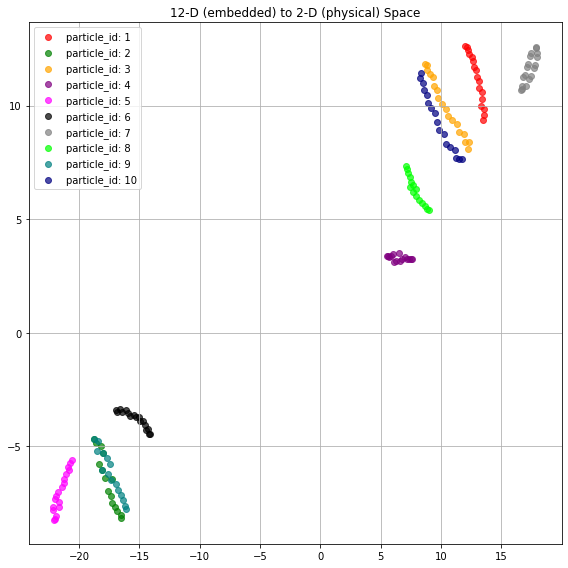

In [40]:
# Using Object Oriented API
plt.close('all')
fig, ax = plt.subplots(figsize=(8,8))
cmap = get_custom_cmap()

for pid in unique_pids:
    mask = (feature_data.pid == pid)  # filter each pid
    color = cmap(pid % len(cmap.colors))  # cycle through cmap
    ax.scatter(e_spatial_tsne[mask, 0], e_spatial_tsne[mask, 1], color=color, label=f'particle_id: {pid}', alpha=0.7)

ax.set_title(f'{embedding_dim}-D (embedded) to 2-D (physical) Space')
#ax.set_xlabel(f'Dimension {id1}')
#ax.set_ylabel(f'Dimension {id2}')
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
ax.legend(fontsize=10, loc='best')
ax.grid(True)
fig.tight_layout()
fig.savefig("embeding_tsne.png")
# plt.close()

### _4. Edge Building [Fixing]_

- _Main objective of embedding is to construct graphs. In principle, one should extract and visualize these edges._
- _What we need is node features `(x,y,z)`, get node embeddings as `e_spatial` and then extract `edge_index` and `y`._
- _Visualize `signal_true_edges`, `edge_index` to see truth graph and constructed graph for an event._

In [41]:
from LightningModules.edge_construction.utils.embedding_utils import build_edges

In [42]:
# build edges
e_spatial = build_edges(e_spatial, e_spatial, indices=None, r_max=0.1, k_max=100)

In [43]:
e_spatial.shape

torch.Size([2, 826])

In [44]:
e_spatial

tensor([[  0,   0,   0,  ..., 163, 164, 164],
        [  1,   2, 115,  ..., 161, 163, 162]])

In [45]:
# get first three pairs/edges. use all rows but cols=0,1,2
# e_spatial[:, 0], e_spatial[:, 1], e_spatial[:, 2]

In [46]:
# convert e_spatial tensor to numpy version e_spatial_np
e_spatial_np = e_spatial.detach().numpy()

In [47]:
# 1st row
# e_spatial_np[0]

In [48]:
# 2nd row
# e_spatial_np[1]

In [49]:
# edge/pair = 1st row first element, 2nd row 1st element
# e_spatial_np[0, 0], e_spatial_np[1, 0]

In [50]:
# hit=1 (0) of one pair is also paired next with hit=13 (12) forming another pair.
# e_spatial_np[0, 1], e_spatial_np[1, 1]

In [51]:
# access hi1=1 (0) in pair 0 and pair 1.
# e_spatial_np[0, 0], e_spatial_np[0, 1]

In [52]:
# Why ???
# hits.iloc[[e_spatial[0, 0], e_spatial[0, 1]]].x.values

#### _Ploting Edges_

In [53]:
from src.math_utils import polar_to_cartesian

In [54]:
# lets get transpose of e_spatial
e_spatial_np_t = e_spatial_np.T

In [55]:
e_spatial_np.shape

(2, 826)

In [56]:
e_spatial_np_t.shape

(826, 2)

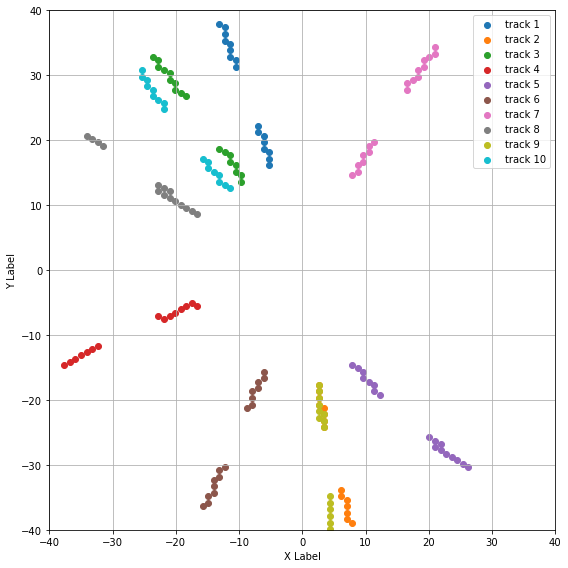

In [57]:
# plotting event from processing stage i.e. feature_data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for pid in unique_pids:
    idx = feature_data.pid == pid
    x, y = polar_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1])
    ax.scatter(x[idx], y[idx], label='track %d'%pid)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.legend(fontsize=10, loc='best')
ax.grid(True)
fig.tight_layout()
# plt.savefig(os.path.join(outdir, "embeding-tsne.png"))

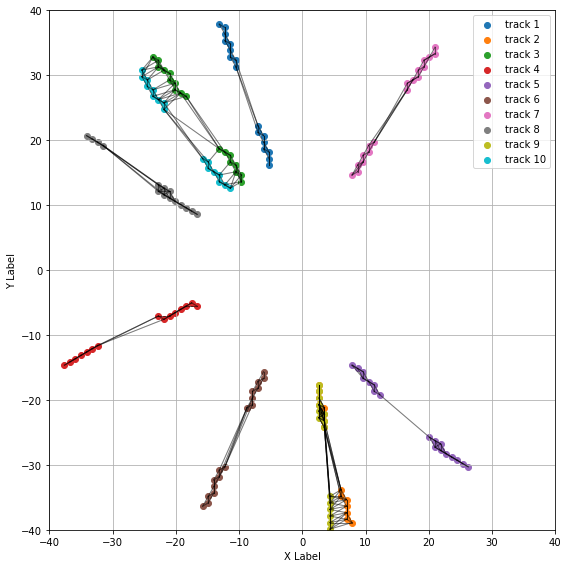

In [58]:
# plot edges 3D: data from processing stage, edges from embedding stage
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for pid in unique_pids:
    idx = feature_data.pid == pid
    x, y = polar_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1])
    ax.scatter(x[idx], y[idx], label='track %d'%pid)


# add edges (hits=runs from 0 to 256, edges goes all the way to 5)
e_spatial_np_t = e_spatial_np.T
for iedge in range(e_spatial_np.shape[1]):
    x, y = polar_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1])
    ax.plot(x[e_spatial_np_t[iedge]], y[e_spatial_np_t[iedge]], color='k', alpha=0.3, lw=1.)
    

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.legend(fontsize=10, loc='best')
ax.grid(True)
fig.tight_layout()
# plt.savefig(os.path.join(outdir, "emedding_edges_3d.pdf"))

NameError: name 'hits' is not defined

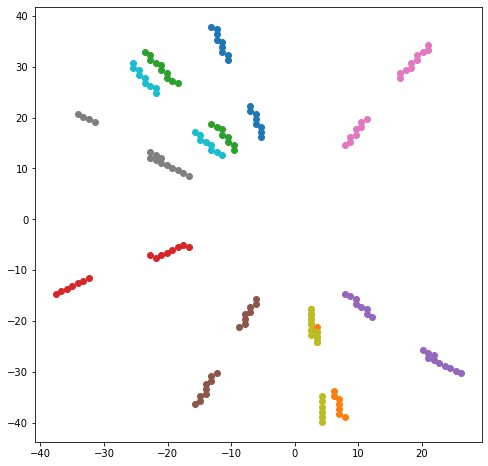

In [59]:
# plot edges 2D: data from processing stage, edges from embedding stage
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for pid in unique_pids:
    idx = feature_data.pid == pid
    x, y = polar_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1])
    ax.scatter(x[idx], y[idx], label='track %d'%pid)

# add edges (hits=runs from 0 to 256, edges goes all the way to 5)
e_spatial_np_t = e_spatial_np.T
# for iedge in range(e_spatial_np.shape[1]):
for iedge in range(100):
    ax.plot(hits.iloc[e_spatial_np_t[iedge]].x.values, hits.iloc[e_spatial_np_t[iedge]].y.values, color='k', alpha=0.3, lw=1.)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.legend(fontsize=10, loc='best')
ax.grid(True)
fig.tight_layout()
# plt.savefig(os.path.join(outdir, "embedding_edges_x_y.pdf"))

In [ ]:
# plot edges 2D: data from processing stage, edges from embedding stage
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for pid in unique_pids:
    idx = feature_data.pid == pid
    ax.scatter(feature_data.x[:, 2][idx], feature_data.x[:, 0][idx], label='track %d'%pid)

# add edges
e_spatial_np_t = e_spatial_np.T
# for iedge in range(e_spatial_np.shape[1]):
for iedge in range(100):
    ax.plot(feature_data.x[:, 2][e_spatial_np_t[iedge]], feature_data.x[:, 0][e_spatial_np_t[iedge]], color='k', alpha=0.3, lw=1.)

ax.set_xlabel('Z')
ax.set_ylabel('R')
#ax.set_xlim(-40, 100)
#ax.set_ylim(0, 50)
ax.legend(fontsize=10, loc='best')
ax.grid(True)
fig.tight_layout()
# plt.savefig(os.path.join(outdir, "embedding_edges_z_r.pdf"))

### Plotting Hists
- following plots need r, phi, z coordinates.